In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score





import warnings
warnings.filterwarnings('ignore')

## 데이터 확인

In [2]:
card2021 = dd.read_csv(r'훈련생 전달용\iMBANK_CARD_DATA_2021(K-DigitalTraining)\iMBANK_CARD_DATA_2021(K-DigitalTraining).csv', encoding = 'cp949')

In [3]:
df1 = card2021.compute()

In [4]:
df2 = pd.read_csv('df.csv')

In [31]:
df2

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,최다가맹점업종명,업종다양성지수,신규유입고객,최다가맹점_광역시도,거래지역다양성지수,총거래금액,총거래건수
0,2002967708,202312,202312,1,100.00,5.00,0.00,0,210000.00,5.00,대형할인점,2,1,경상북도,2,210000,5.0
1,2004066711,202312,202312,1,100.00,2.50,0.00,0,40000.00,2.50,대형할인점,1,1,경기도,1,40000,2.5
2,2004166649,202312,202312,1,100.00,15.00,0.00,0,220000.00,15.00,기타잡화,6,1,경상북도,3,220000,15.0
3,2004326617,202312,202312,1,100.00,2.50,0.00,0,10000.00,2.50,편 의 점,1,1,경기도,1,10000,2.5
4,2004432929,202312,202312,1,100.00,5.00,0.00,0,460000.00,5.00,대형할인점,2,1,경기도,2,460000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915212,9999918728,202105,202310,30,43.33,4.23,0.57,17,443076.92,4.23,대형할인점,6,1,대구광역시,1,5760000,55.0
915213,9999933174,202109,202212,16,43.75,9.29,0.56,9,611428.57,9.29,약 국,14,1,경기도,4,4280000,65.0
915214,9999972286,202101,202101,1,100.00,2.50,0.00,0,10000.00,2.50,편 의 점,1,0,대구광역시,1,10000,2.5
915215,9999981183,202101,202211,23,100.00,21.20,0.00,0,371304.35,21.20,일반한식,31,0,경상북도,6,8540000,487.5


## 파생변수 생성

In [5]:
df1['승인건수점수'] = 0

df1['승인건수점수'] = df1['승인건수'].apply(lambda x: 1 if x == '5번이하' else 
                                              2 if x == '5번초과 10번이하' else 
                                              3 if x == '10번초과 15번이하' else 
                                              4 if x == '15번초과 20번이하' else 
                                              5 if x == '20번 초과' else 0)

In [6]:
df1['승인건수평균'] = 0

df1['승인건수평균'] = df1['승인건수'].apply(lambda x: 2.5 if x == '5번이하' else 
                                              7.5 if x == '5번초과 10번이하' else 
                                              12.5 if x == '10번초과 15번이하' else 
                                              17.5 if x == '15번초과 20번이하' else 
                                              22.5 if x == '20번 초과' else 0)

In [7]:
df1['승인금액2'] = df1['승인금액'] / df1['승인건수평균']
df1['승인금액점수'] = 0

df1['승인금액점수'] = df1['승인금액2'].apply(lambda x: 1 if x <= 10000 else 
                                              2 if 10000 < x <= 40000 else 
                                              3 if 40000 < x <= 80000 else 
                                              4 if 80000 < x <= 1300000 else 
                                              5 if 130000 < x <= 3000000 else 
                                              6 if 300000 < x  else 0)

In [8]:
df1['승인점수'] = df1['승인건수점수'] + df1['승인금액점수']

## df1정리

In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60672642 entries, 0 to 1070004
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   거래년월      int64  
 1   고객ID      int64  
 2   가맹점업종명    string 
 3   가맹점_광역시도  string 
 4   가맹점_시군구   string 
 5   승인건수      string 
 6   승인금액      int64  
 7   승인건수점수    int64  
 8   승인건수평균    float64
 9   승인금액2     float64
 10  승인금액점수    int64  
 11  승인점수      int64  
dtypes: float64(2), int64(6), string(4)
memory usage: 8.5 GB


In [21]:
df1.shape[0]

43831125

In [9]:
df1['거래년월'] = df1['거래년월'].astype(int)
df1 = df1.loc[df1.groupby('고객ID')['거래년월'].idxmax()]

In [10]:
df1 = df1[['고객ID','승인건수점수','승인금액점수','승인점수']]

## df2랑 정리

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915217 entries, 0 to 915216
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   고객ID         915217 non-null  int64  
 1   최초거래년월       915217 non-null  int64  
 2   최종거래년월       915217 non-null  int64  
 3   거래활동기간       915217 non-null  int64  
 4   거래 연속성 비율    915217 non-null  float64
 5   거래 밀도 지수     915217 non-null  float64
 6   비활성화 기간 비율   915217 non-null  float64
 7   총 거래 공백 개월수  915217 non-null  int64  
 8   월평균 거래금액     915217 non-null  float64
 9   월평균 거래건수     915217 non-null  float64
 10  최다가맹점업종명     915217 non-null  object 
 11  업종다양성지수      915217 non-null  int64  
 12  신규유입고객       915217 non-null  int64  
 13  최다가맹점_광역시도   915217 non-null  object 
 14  거래지역다양성지수    915217 non-null  int64  
 15  총거래금액        915217 non-null  int64  
 16  총거래건수        915217 non-null  float64
dtypes: float64(6), int64(9), object(2)
memory usage: 118.7+ MB


In [22]:
df2.shape[0]

915217

In [11]:
data = pd.merge(df2, df1, on='고객ID', how='inner')

In [12]:
columns_to_drop = [col for col in data.columns if col.endswith('_y')]
data = data.drop(columns=columns_to_drop)

In [25]:
data

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,최다가맹점업종명,업종다양성지수,신규유입고객,최다가맹점_광역시도,거래지역다양성지수,총거래금액,총거래건수,승인건수점수,승인금액점수,승인점수
0,2800789394,202112,202205,6,100.00,55.83,0.00,0,563333.33,55.83,택시,13,1,부산광역시,2,3380000,335.0,1,1,2
1,2801555204,202112,202311,24,95.83,20.65,0.04,1,58695.65,20.65,편 의 점,12,1,대구광역시,3,1350000,475.0,1,1,2
2,2801555204,202112,202311,24,95.83,20.65,0.04,1,58695.65,20.65,편 의 점,12,1,대구광역시,3,1350000,475.0,1,1,2
3,2801835265,202112,202209,10,70.00,17.50,0.30,3,117142.86,17.50,서양음식,17,1,대구광역시,4,820000,122.5,1,1,2
4,2801835265,202112,202209,10,70.00,17.50,0.30,3,117142.86,17.50,서양음식,17,1,대구광역시,4,820000,122.5,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43831120,9999998161,202101,202311,35,60.00,8.93,0.40,14,71904.76,8.93,택시,14,0,대구광역시,1,1510000,187.5,1,1,2
43831121,9999998161,202101,202311,35,60.00,8.93,0.40,14,71904.76,8.93,택시,14,0,대구광역시,1,1510000,187.5,1,1,2
43831122,9999998161,202101,202311,35,60.00,8.93,0.40,14,71904.76,8.93,택시,14,0,대구광역시,1,1510000,187.5,1,2,3
43831123,9999998161,202101,202311,35,60.00,8.93,0.40,14,71904.76,8.93,택시,14,0,대구광역시,1,1510000,187.5,1,1,2


In [13]:
data = data[['거래활동기간','업종다양성지수','거래지역다양성지수',
             '총거래금액','총거래건수','거래 연속성 비율','거래 밀도 지수','승인점수','승인건수점수','승인금액점수','최다가맹점업종명']]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43831125 entries, 0 to 43831124
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   거래활동기간     int64  
 1   업종다양성지수    int64  
 2   거래지역다양성지수  int64  
 3   총거래금액      int64  
 4   총거래건수      float64
 5   거래 연속성 비율  float64
 6   거래 밀도 지수   float64
 7   승인점수       int64  
 8   승인건수점수     int64  
 9   승인금액점수     int64  
 10  최다가맹점업종명   object 
dtypes: float64(3), int64(7), object(1)
memory usage: 3.6+ GB


## 전처리

In [14]:
value_counts = data['최다가맹점업종명'].value_counts() 
data['업종빈도'] = data['최다가맹점업종명'].map(value_counts) 

In [15]:
features1 = ['거래활동기간', '업종다양성지수', '거래지역다양성지수', '총거래금액', '총거래건수', '거래 연속성 비율', '거래 밀도 지수','승인점수', 
             '승인건수점수', '승인금액점수', '업종빈도']

In [16]:
df1 = data[features1].dropna()  
scaler = StandardScaler() 
df_scaled1 = scaler.fit_transform(df1) 
df_final = pd.DataFrame(df_scaled1, columns=df1.columns) 

## 주성분 수 선택

In [17]:
df_final = df_final.apply(pd.to_numeric, errors='coerce')

In [ ]:
pca = PCA() 
pca.fit(df_final)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('누적설명분산비율그래프')
plt.show()

In [22]:
columns = ['거래활동기간', '업종다양성지수', '거래지역다양성지수', '총거래금액', '총거래건수', '거래 연속성 비율', 
           '거래 밀도 지수', '승인점수', '승인건수점수', '승인금액점수', '업종빈도']
pca_components_df = pd.DataFrame(pca.components_, columns=columns)
print(pca_components_df.iloc[0])

#총거래건수 > 업종다양성지수 > 거래 밀도 지수 

거래활동기간       0.193503
업종다양성지수      0.437225
거래지역다양성지수    0.366636
총거래금액        0.389430
총거래건수        0.447572
거래 연속성 비율    0.238661
거래 밀도 지수     0.429486
승인점수         0.042619
승인건수점수       0.019459
승인금액점수       0.037737
업종빈도         0.199891
Name: 0, dtype: float64


## 새 데이터셋

In [23]:
dataset = df_final[['총거래건수', '업종다양성지수', '거래 밀도 지수','승인점수','승인금액점수']]

In [24]:
dataset

,총거래건수,업종다양성지수,거래 밀도 지수,승인점수,승인금액점수
0,-0.965286,-1.653420,0.298384,-0.777900,-0.771230
1,-0.851784,-1.712226,-0.736434,-0.777900,-0.771230
2,-0.851784,-1.712226,-0.736434,-0.777900,-0.771230
3,-1.137568,-1.418196,-0.829091,-0.777900,-0.771230
4,-1.137568,-1.418196,-0.829091,-0.777900,-0.771230
...,...,...,...,...,...
43831120,-1.084870,-1.594614,-1.081177,-0.777900,-0.771230
43831121,-1.084870,-1.594614,-1.081177,-0.777900,-0.771230
43831122,-1.084870,-1.594614,-1.081177,0.460741,0.588759
43831123,-1.084870,-1.594614,-1.081177,-0.777900,-0.771230


## 군집 수 선택

In [ ]:
inertia = []
K = range(1, 10) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

## 군집 결과

In [28]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(dataset)

MemoryError: Unable to allocate 1.63 GiB for an array with shape (43831125, 5) and data type float64

In [27]:
kmeans2 = KMeans(n_clusters=5, random_state=42)
df['Cluster2'] = kmeans2.fit_predict(df_scaled)

NameError: name 'df_scaled' is not defined

In [12]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

             승인점수    승인건수점수    승인금액점수         승인금액2          승인금액
Cluster                                                          
0        2.387315  1.039680  1.347636  1.166696e+04  3.081069e+04
1        2.952941  1.051559  1.901382  3.043224e+04  8.154820e+04
2        4.327742  1.049175  3.278568  1.470840e+05  3.849345e+05
3        5.131127  1.061071  4.070056  1.039191e+06  2.700687e+06


In [18]:
cluster_summary2 = df.groupby('Cluster2').mean()
print(cluster_summary2)

              승인점수    승인건수점수    승인금액점수          승인금액2          승인금액   Cluster
Cluster2                                                                     
0         2.932873  1.028174  1.904699   30445.267946  7.999975e+04  0.965251
1         4.298945  1.014243  3.284702  144977.259942  3.713744e+05  1.983305
2         5.071125  1.051943  4.019181  962444.245486  2.493195e+06  2.833051
3         2.380845  1.036274  1.344570   11603.602251  3.064497e+04  0.006974
4         3.182823  1.702724  1.480099   16553.269655  9.331111e+04  0.695684


In [19]:
df

,승인점수,승인건수점수,승인금액점수,승인금액2,승인금액,Cluster,Cluster2
0,2.500000,1.000000,1.500000,10000.000000,2.500000e+04,0,3
1,2.000000,1.000000,1.000000,4000.000000,1.000000e+04,0,3
2,2.000000,1.000000,1.000000,4000.000000,1.000000e+04,0,3
3,3.000000,1.000000,2.000000,28000.000000,7.000000e+04,1,0
4,4.750000,1.000000,3.750000,440000.000000,1.100000e+06,2,1
...,...,...,...,...,...,...,...
769848,3.583333,1.083333,2.500000,80777.777778,3.075000e+05,2,1
769849,2.714286,1.000000,1.714286,14857.142857,3.714286e+04,1,0
769850,2.000000,1.000000,1.000000,4000.000000,1.000000e+04,0,3
769851,2.608333,1.016667,1.591667,18020.000000,4.525000e+04,0,3


## 시각화

In [26]:
correlation_matrix = df.corr()
correlation_matrix

,승인점수,승인건수점수,승인금액점수,승인금액2,승인금액,Cluster,Cluster2
승인점수,1.000000,0.176654,0.967272,0.583342,0.600612,0.832089,-0.557818
승인건수점수,0.176654,1.000000,-0.078878,-0.039129,0.051837,0.042136,0.170492
승인금액점수,0.967272,-0.078878,1.000000,0.600903,0.594944,0.831888,-0.608917
승인금액2,0.583342,-0.039129,0.600903,1.000000,0.977601,0.493039,-0.214061
승인금액,0.600612,0.051837,0.594944,0.977601,1.000000,0.499198,-0.204895
Cluster,0.832089,0.042136,0.831888,0.493039,0.499198,1.000000,-0.815778
Cluster2,-0.557818,0.170492,-0.608917,-0.214061,-0.204895,-0.815778,1.000000


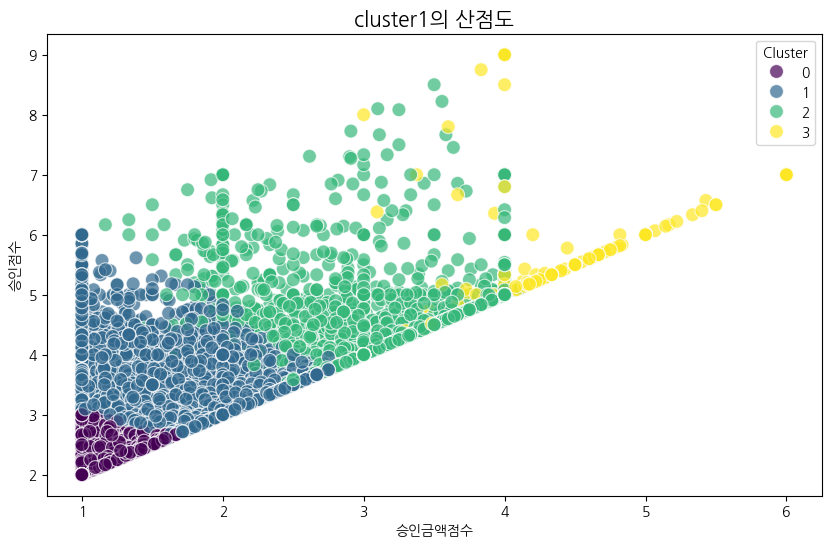

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='승인금액점수', y='승인점수', hue='Cluster', palette='viridis', s=100, alpha=0.7)

plt.title('cluster1의 산점도', fontsize=15)

plt.legend(title='Cluster')

plt.show()

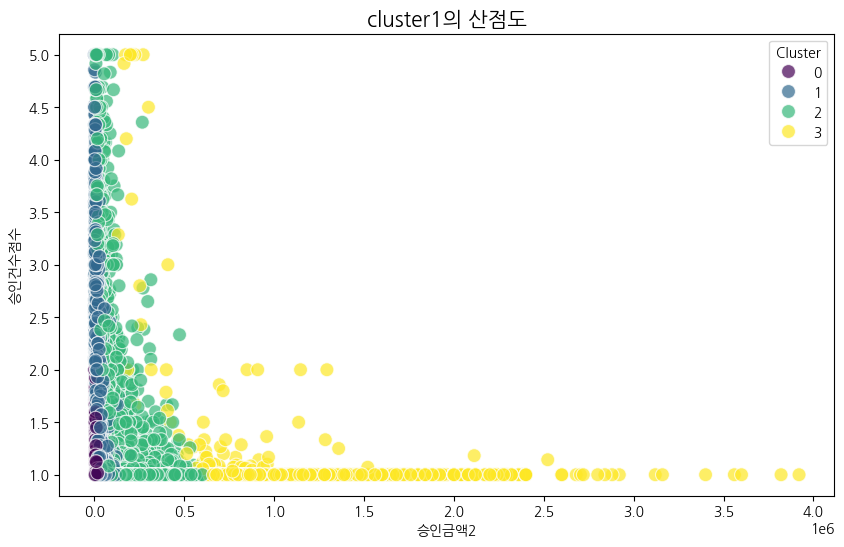

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='승인금액2', y='승인건수점수', hue='Cluster', palette='viridis', s=100, alpha=0.7)

plt.title('cluster1의 산점도', fontsize=15)

plt.legend(title='Cluster')

plt.show()

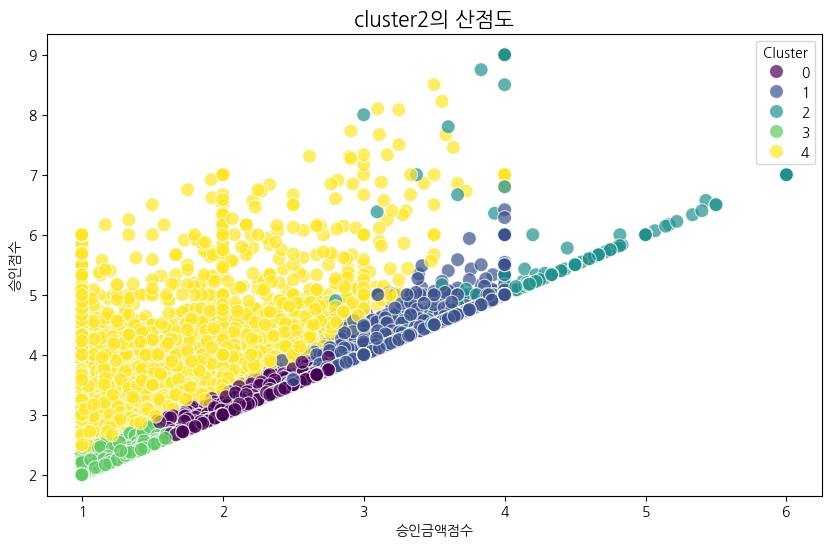

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='승인금액점수', y='승인점수', hue='Cluster2', palette='viridis', s=100, alpha=0.7)

plt.title('cluster2의 산점도', fontsize=15)

plt.legend(title='Cluster')

plt.show()

## 평가

In [ ]:
labels = kmeans.fit_predict(df_scaled)

sil_score = silhouette_score(df_scaled, labels)

print(sil_score)

In [ ]:
labels2 = kmeans2.fit_predict(df_scaled)

sil_score2 = silhouette_score(df_scaled, labels2)

print(sil_score2)